# Extract Cards from Images using OBB Model

This notebook:
1. Loads an OBB model trained to detect cards
2. Runs inference on a folder of images
3. Extracts and crops each detected card
4. Saves cropped cards to an output folder for Label Studio labeling

## 1) Setup

In [1]:
from config_loader import CONFIG

In [2]:
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

In [3]:
from yolo_model import ObbModel, ObbInference
from public_models.obb_type import ObbType

## 2) Configuration

In [4]:
# ============================================================
# === CONFIGURATION ===
# ============================================================

# Path to trained OBB model weights
MODEL_PATH = Path(r"C:\Users\floot\Downloads\best.pt")

# Input: Folder containing images to process
INPUT_IMAGES_DIR = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\frames_from_videos_clips_cropped")

# Output: Folder where extracted cards will be saved
OUTPUT_CARDS_DIR = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\only_cards_from_frames")

# Model inference settings
IMG_SIZE = 1024
CONFIDENCE = 0.50
IOU_THRESHOLD = 0.5
MAX_DETECTIONS = 20
DEVICE = 0  # GPU index, or 'cpu'

# Extraction settings
EXTRACT_CLASSES = [ObbType.CARD]  # Only extract cards (not Card_Holder, Trap)
MIN_CONFIDENCE = 0.5  # Minimum confidence to extract
PADDING = 5  # Pixels of padding around the crop

# Output image settings
OUTPUT_FORMAT = ".jpg"  # .jpg or .png
JPEG_QUALITY = 95

## 3) Load OBB Model

In [6]:
obb_model = ObbModel(
    path=MODEL_PATH,
    imgsz=IMG_SIZE,
    conf=CONFIDENCE,
    iou=IOU_THRESHOLD,
    device=DEVICE,
    verbose=False,
    max_det=MAX_DETECTIONS
)

2025-12-28 18:25:18.303 |   INFO   | [   ObbModel    ] | [obb] YOLO model loaded: C:\Users\floot\Downloads\best.pt


## 4) Card Extraction Functions

In [7]:
def get_perspective_transform_crop(
    img: np.ndarray,
    box: np.ndarray,
    padding: int = 0
) -> np.ndarray:
    """
    Extract a card using perspective transform to get a rectangular crop.
    
    Args:
        img: Source image
        box: OBB box with 4 points [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        padding: Padding around the crop
    
    Returns:
        Cropped and rectified card image
    """
    # Get box dimensions
    pts = box.astype(np.float32)
    
    # Calculate width and height from the OBB
    width1 = np.linalg.norm(pts[0] - pts[1])
    width2 = np.linalg.norm(pts[3] - pts[2])
    width = int(max(width1, width2)) + 2 * padding
    
    height1 = np.linalg.norm(pts[0] - pts[3])
    height2 = np.linalg.norm(pts[1] - pts[2])
    height = int(max(height1, height2)) + 2 * padding
    
    # Destination points for perspective transform
    dst_pts = np.array([
        [padding, padding],
        [width - padding - 1, padding],
        [width - padding - 1, height - padding - 1],
        [padding, height - padding - 1]
    ], dtype=np.float32)
    
    # Compute perspective transform
    M = cv2.getPerspectiveTransform(pts, dst_pts)
    
    # Apply transform
    cropped = cv2.warpPerspective(img, M, (width, height))
    
    return cropped


def get_bounding_box_crop(
    img: np.ndarray,
    box: np.ndarray,
    padding: int = 0
) -> np.ndarray:
    """
    Extract a card using axis-aligned bounding box (simpler, keeps rotation).
    
    Args:
        img: Source image
        box: OBB box with 4 points
        padding: Padding around the crop
    
    Returns:
        Cropped card image (may include background if rotated)
    """
    h, w = img.shape[:2]
    
    # Get bounding rectangle
    x_min = max(0, int(box[:, 0].min()) - padding)
    x_max = min(w, int(box[:, 0].max()) + padding)
    y_min = max(0, int(box[:, 1].min()) - padding)
    y_max = min(h, int(box[:, 1].max()) + padding)
    
    return img[y_min:y_max, x_min:x_max].copy()


def extract_cards_from_image(
    img: np.ndarray,
    inferences: list[ObbInference],
    extract_classes: list[ObbType],
    min_confidence: float,
    padding: int,
    use_perspective: bool = True
) -> list[tuple[np.ndarray, ObbInference]]:
    """
    Extract all matching cards from an image.
    
    Args:
        img: Source image
        inferences: List of OBB inferences
        extract_classes: Classes to extract
        min_confidence: Minimum confidence threshold
        padding: Padding around crops
        use_perspective: Use perspective transform (True) or bounding box (False)
    
    Returns:
        List of (cropped_image, inference) tuples
    """
    extracted = []
    
    for inf in inferences:
        # Filter by class and confidence
        if inf.obb_type not in extract_classes:
            continue
        if inf.confidence < min_confidence:
            continue
        
        # Extract crop
        if use_perspective:
            crop = get_perspective_transform_crop(img, inf.box, padding)
        else:
            crop = get_bounding_box_crop(img, inf.box, padding)
        
        if crop.size > 0:
            extracted.append((crop, inf))
    
    return extracted

## 5) Process Images

In [8]:
# Validate paths
assert INPUT_IMAGES_DIR.exists(), f"Input directory not found: {INPUT_IMAGES_DIR}"

# Create output directory
OUTPUT_CARDS_DIR.mkdir(parents=True, exist_ok=True)

# Get list of images
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
image_paths = [
    p for p in INPUT_IMAGES_DIR.rglob("*")
    if p.suffix.lower() in IMAGE_EXTENSIONS
]

print(f"Found {len(image_paths)} images to process")
print(f"Output directory: {OUTPUT_CARDS_DIR.resolve()}")

Found 440 images to process
Output directory: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\only_cards_from_frames


In [9]:
# Process all images
total_cards = 0
stats = {"processed": 0, "cards_extracted": 0, "errors": []}

for img_path in tqdm(image_paths, desc="Processing images"):
    try:
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            stats["errors"].append(f"Failed to load: {img_path.name}")
            continue
        
        # Run inference
        inferences = obb_model.infer(img)
        
        # Extract cards
        extracted = extract_cards_from_image(
            img=img,
            inferences=inferences,
            extract_classes=EXTRACT_CLASSES,
            min_confidence=MIN_CONFIDENCE,
            padding=PADDING,
            use_perspective=True
        )
        
        # Save extracted cards
        for i, (crop, inf) in enumerate(extracted):
            # Generate output filename
            card_name = f"{img_path.stem}_card{i+1:02d}_{inf.obb_type.value}_conf{inf.confidence:.2f}{OUTPUT_FORMAT}"
            output_path = OUTPUT_CARDS_DIR / card_name
            
            # Save image
            if OUTPUT_FORMAT == ".jpg":
                cv2.imwrite(str(output_path), crop, [cv2.IMWRITE_JPEG_QUALITY, JPEG_QUALITY])
            else:
                cv2.imwrite(str(output_path), crop)
            
            total_cards += 1
        
        stats["processed"] += 1
        stats["cards_extracted"] += len(extracted)
        
    except Exception as e:
        stats["errors"].append(f"{img_path.name}: {str(e)}")

print(f"\n{'='*50}")
print(f"EXTRACTION COMPLETE")
print(f"{'='*50}")
print(f"Images processed: {stats['processed']}")
print(f"Cards extracted: {stats['cards_extracted']}")
print(f"Errors: {len(stats['errors'])}")
print(f"\nOutput: {OUTPUT_CARDS_DIR.resolve()}")

Processing images: 100%|██████████| 440/440 [02:00<00:00,  3.64it/s]


EXTRACTION COMPLETE
Images processed: 440
Cards extracted: 1541
Errors: 0

Output: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\only_cards_from_frames


## 6) Preview Extracted Cards

Total extracted cards: 1541


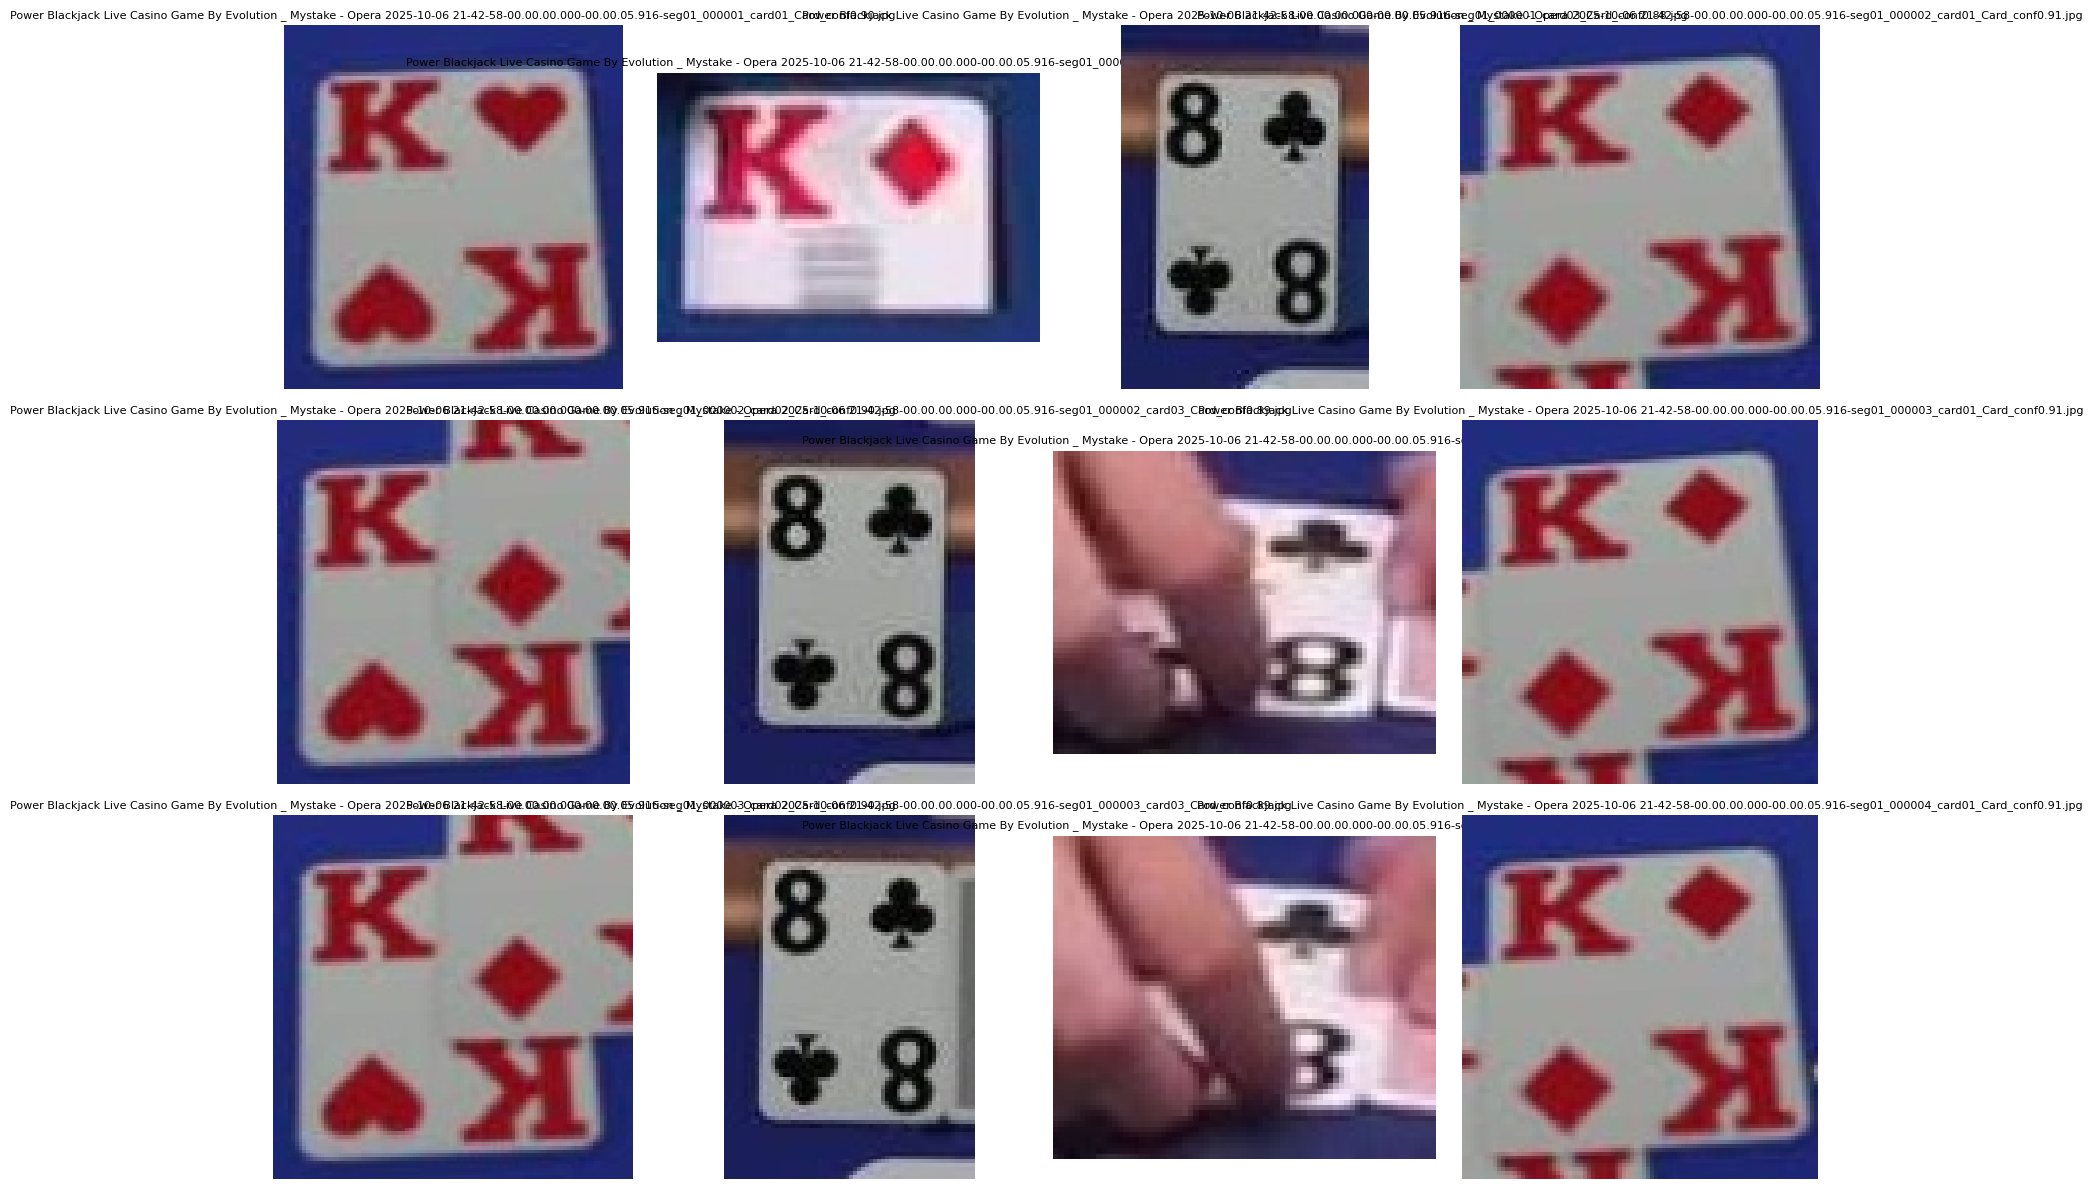

In [10]:
import matplotlib.pyplot as plt

# Get extracted cards
extracted_files = list(OUTPUT_CARDS_DIR.glob(f"*{OUTPUT_FORMAT}"))
print(f"Total extracted cards: {len(extracted_files)}")

# Show first 12 cards
n_show = min(12, len(extracted_files))
if n_show > 0:
    cols = 4
    rows = (n_show + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten() if n_show > 1 else [axes]
    
    for i, card_path in enumerate(extracted_files[:n_show]):
        img = cv2.imread(str(card_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(card_path.name, fontsize=8)
        axes[i].axis("off")
    
    # Hide empty subplots
    for i in range(n_show, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

## 7) Visualize Detections on Original Images

In [11]:
def draw_obb_detections(
    img: np.ndarray,
    inferences: list[ObbInference],
    line_thickness: int = 2
) -> np.ndarray:
    """
    Draw OBB detections on an image.
    """
    img_draw = img.copy()
    
    colors = {
        ObbType.CARD: (0, 255, 0),
        ObbType.CARD_HOLDER: (255, 0, 0),
        ObbType.TRAP: (0, 0, 255),
        ObbType.UNKNOWN: (128, 128, 128),
    }
    
    for inf in inferences:
        pts = inf.box.astype(np.int32)
        color = colors.get(inf.obb_type, (255, 255, 255))
        
        # Draw polygon
        cv2.polylines(img_draw, [pts], True, color, line_thickness)
        
        # Draw label
        label = f"{inf.obb_type.value} {inf.confidence:.2f}"
        cv2.putText(
            img_draw, label,
            (int(pts[0, 0]), int(pts[0, 1]) - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )
    
    return img_draw

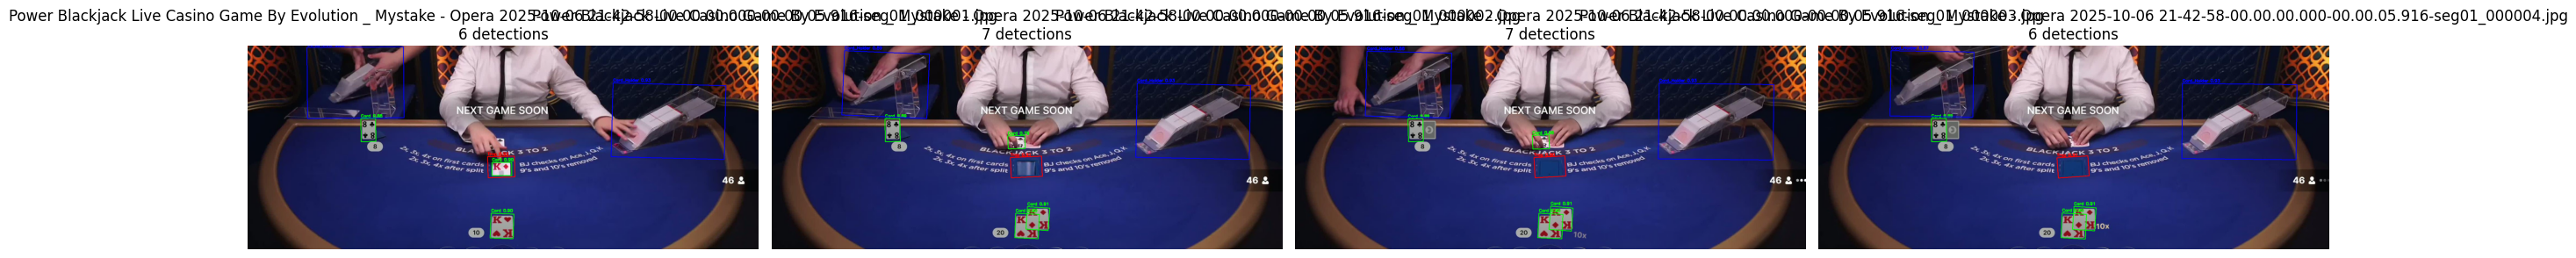

In [12]:
# Visualize detections on a few sample images
n_samples = min(4, len(image_paths))

fig, axes = plt.subplots(1, n_samples, figsize=(6 * n_samples, 6))
if n_samples == 1:
    axes = [axes]

for i, img_path in enumerate(image_paths[:n_samples]):
    img = cv2.imread(str(img_path))
    inferences = obb_model.infer(img)
    
    img_vis = draw_obb_detections(img, inferences)
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img_vis)
    axes[i].set_title(f"{img_path.name}\n{len(inferences)} detections")
    axes[i].axis("off")

plt.tight_layout()
plt.show()